# Рекомендация тарифов

# Описание проекта

Необходимо дать рекомендацию клиенту о переходе на один из тарифов "Смарт" или "Ультра".


<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-анализ-данных" data-toc-modified-id="Загрузка-и-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и анализ данных</a></span></li><li><span><a href="#Разделение-на-обучающую,-валидационную-и-тестовые-выборки." data-toc-modified-id="Разделение-на-обучающую,-валидационную-и-тестовые-выборки.-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Разделение на обучающую, валидационную и тестовые выборки.</a></span><ul class="toc-item"><li><span><a href="#Дерево-решений." data-toc-modified-id="Дерево-решений.-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Дерево решений.</a></span></li><li><span><a href="#Случайный-лес." data-toc-modified-id="Случайный-лес.-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Случайный лес.</a></span></li><li><span><a href="#Логистическая-регрессия." data-toc-modified-id="Логистическая-регрессия.-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Логистическая регрессия.</a></span></li></ul></li><li><span><a href="#Проверка-моделей-на-адекватность." data-toc-modified-id="Проверка-моделей-на-адекватность.-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Проверка моделей на адекватность.</a></span></li><li><span><a href="#Вывод." data-toc-modified-id="Вывод.-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод.</a></span></li></ul></div>

## Загрузка и анализ данных

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
data.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Насколько я помню, Мегалайн округляет мегабайты до гигабайт в б**о**льшую сторону.

In [5]:
data['gb_used'] = (data['mb_used']/1024).apply(np.ceil).astype('int64')

Минуты тоже округляются в б**о**льшую сторону, хотя и для каждого разговора. Но за неимением исходных данных, округлим данные за месяц.

In [6]:
data['minutes']=data['minutes'].apply(np.ceil).astype('int64')

Количество звонков и СМС переведем в целое число.

In [7]:
data[['calls','messages']] = data[['calls','messages']].astype('int64')

In [8]:
data.head()

,calls,minutes,messages,mb_used,is_ultra,gb_used
0,40,312,83,19915.42,0,20
1,85,517,56,22696.96,0,23
2,77,468,86,21060.45,0,21
3,106,746,81,8437.39,1,9
4,66,419,1,14502.75,0,15


Посчитаем, сколько пользователей на разных тарифах.

In [9]:
data['is_ultra'].sum()

985

In [10]:
len(data)-data['is_ultra'].sum()

2229

In [11]:
(len(data)-data['is_ultra'].sum())/len(data)

0.693528313627878

Если мы просто скажем, что все тарифы это Смарт, то точность будет 0.69, еще немного и получилась бы нужная точность в 0.75.

## Разделение на обучающую, валидационную и тестовые выборки.

Разделим данные на обучающую, валидационную и тестовые выборки в отношении 3:1:1. Для разделения будем использовать стратификацию по тарифу.

In [12]:
features = data.drop(columns=['mb_used','is_ultra'])
target = data['is_ultra']

In [13]:
features_train,features_check, target_train, target_check = train_test_split(features, target,
                                                                             stratify=target,test_size=0.4,
                                                                            random_state=12345)
features_validate,features_test,target_validate,target_test = train_test_split(features_check,target_check,
                                                                              stratify=target_check,
                                                                              test_size=0.5,
                                                                               random_state=12345)

In [14]:
features_train.shape

(1928, 4)

In [15]:
features_validate.shape

(643, 4)

In [16]:
features_test.shape

(643, 4)

Посмотрим на наличие парных корреляций.


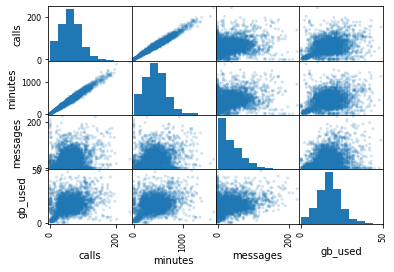

In [17]:
pd.plotting.scatter_matrix(features, alpha=0.2)
plt.show()

Похоже, что количество звонков и количество минут имеют сильную корреляцию и могут ухудшить прогноз. Можно оставить только количество минут.

In [18]:
features_train_no_calls = features_train.drop(columns=['calls'])
features_validate_no_calls = features_validate.drop(columns=['calls'])
features_test_no_calls = features_test.drop(columns=['calls'])

# Качество разных моделей.

### Дерево решений.

Начнем с дерева решений с параметрами по умолчанию.

In [19]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train, target_train)

DecisionTreeClassifier(random_state=12345)

In [20]:
predictions_validate = model.predict(features_validate)

In [21]:
accuracy_validate = accuracy_score(target_validate, predictions_validate)
accuracy_validate

0.7076205287713841

Точность почти как если бы мы все записали в Смарт. До 0.75 немного не хватает, попробуем поменять глубину дерева решений.

In [22]:
acc=[]
for i in range(1,50):
    model = DecisionTreeClassifier(random_state=12345, max_depth=i)
    model.fit(features_train, target_train)
    predictions_validate = model.predict(features_validate)
    accuracy_validate = accuracy_score(target_validate, predictions_validate)
    acc.append(accuracy_validate)
    #print(i,accuracy_validate)

Text(0.5, 0, 'Tree depth')

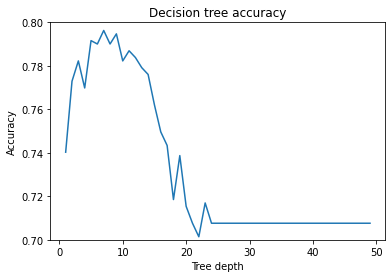

In [23]:
plt.plot(range(1,50),acc)
plt.ylim(0.7,0.8)
plt.title('Decision tree accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Tree depth')

При большой глубине дерево решений склонно к переобучению. Максимальная точность достигается при глубине равной 9, но, чтобы избежать переобучения, возьмем глубину равную 5, на ней почти такая же точность.

In [24]:
model = DecisionTreeClassifier(random_state=12345, max_depth=5)
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
accuracy_test = accuracy_score(target_test, predictions_test)
accuracy_test

0.8118195956454122

На тестовой выборке точность тоже получилась больше 0.75.

Посмотрим на метрики recall и precision.

In [25]:
recall_score(target_test, predictions_test)

0.5228426395939086

Похоже, что мы находим далеко не все тарифы Ультра.

In [26]:
precision_score(target_test, predictions_test)

0.7923076923076923

Смарт мы определяем точнее.

Посмотрим на модель, если при обучении мы не будем учитывать кличество звонков. Не будем подбирать новые параметры, возмем те, которые уже есть.

In [27]:
model = DecisionTreeClassifier(random_state=12345, max_depth=5)
model.fit(features_train_no_calls, target_train)
predictions_test = model.predict(features_test_no_calls)
accuracy_test = accuracy_score(target_test, predictions_test)
accuracy_test

0.8040435458786936

Точность практически не изменилась.

In [28]:
recall_score(target_test, predictions_test)

0.4619289340101523

Ультру еще больше недопредсказываем.

In [29]:
precision_score(target_test, predictions_test)

0.8198198198198198

Смарт определяем более уверенно, чем раньше.

### Случайный лес.

In [30]:
model = RandomForestClassifier(random_state=12345)
model.fit(features_train, target_train)
predictions_validate = model.predict(features_validate)
accuracy_validate = accuracy_score(target_validate, predictions_validate)
accuracy_validate

0.7884914463452566

Случайный лес уже по умолчанию дает результат выше 0.75. Попробуем поменять количество деревьев и глубину каждого дерева.

In [31]:
acc=[]
for n_trees in range(10,51,5):
    accc=[]
    for depth in range(1,10):
        model = RandomForestClassifier(n_estimators=n_trees,max_depth = depth,random_state=12345)
        model.fit(features_train, target_train)
        predictions_validate = model.predict(features_validate)
        accuracy_validate = accuracy_score(target_validate, predictions_validate)
        accc.append(accuracy_validate)
    acc.append(accc)

/tmp/ipykernel_204/264873340.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(range(10))
/tmp/ipykernel_204/264873340.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(range(5,51,5))


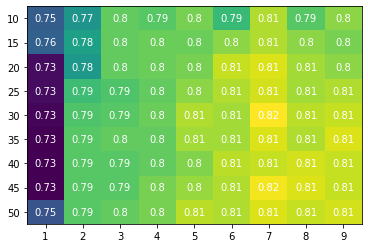

In [32]:
acc = np.array(acc)
fig, ax = plt.subplots()
im = ax.imshow(acc, aspect='auto')
ax.set_xticklabels(range(10))
ax.set_yticklabels(range(5,51,5))

for i in range(9):
    for j in range(9):
        text = ax.text(j, i, round(acc[i, j],2),
                       ha="center", va="center", color="w")


Максимальная точность достигается при 30 деревьях и при глубине дерева 7. Проверим модель на тестовой выборке.

In [33]:
model = RandomForestClassifier(n_estimators=30,max_depth = 7,random_state=12345)
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
accuracy_test = accuracy_score(target_test, predictions_test)
accuracy_test

0.8164852255054432

Посмотрим на метрики recall и precision.

In [34]:
recall_score(target_test, predictions_test)

0.5431472081218274

In [35]:
precision_score(target_test, predictions_test)

0.7925925925925926

Такая же ситуация, недопредсказываем количество тарифов Ультра.

Посмотрим на модель, если не будем учитывать количество звонков.


In [36]:
model = RandomForestClassifier(n_estimators=30,max_depth = 7,random_state=12345)
model.fit(features_train_no_calls, target_train)
predictions_test = model.predict(features_test_no_calls)
accuracy_test = accuracy_score(target_test, predictions_test)
accuracy_test

0.8180404354587869

In [37]:
recall_score(target_test, predictions_test)

0.5025380710659898

In [38]:
precision_score(target_test, predictions_test)

0.8389830508474576

Предсказательная способность модели не ухудшилась.

### Логистическая регрессия.

In [39]:
model = LogisticRegression(random_state=12345)
model.fit(features_train, target_train)
predictions_validate = model.predict(features_validate)
accuracy_validate = accuracy_score(target_validate, predictions_validate)
accuracy_validate

0.7402799377916018

Точности немного не хватает, проверим, что на тестовой выборке.

In [40]:
model = LogisticRegression(random_state=12345)
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
accuracy_test = accuracy_score(target_test, predictions_test)
accuracy_test

0.7480559875583204

Посмотрим на метрики recall и precision.


In [41]:
recall_score(target_test, predictions_test)

0.2233502538071066

Совсем плохо, почти не распознаем тариф Ультра.

In [42]:
precision_score(target_test, predictions_test)

0.8301886792452831

Смарт определяем неплохо.

Посмотрим на модель, если не будем учитывать количество звонков.

In [43]:
model = LogisticRegression(random_state=12345)
model.fit(features_train_no_calls, target_train)
predictions_test = model.predict(features_test_no_calls)
accuracy_test = accuracy_score(target_test, predictions_test)
accuracy_test

0.7465007776049767

In [44]:
recall_score(target_test, predictions_test)

0.2233502538071066

In [45]:
precision_score(target_test, predictions_test)

0.8148148148148148

## Проверка моделей на адекватность.

Проверим модель на адекватность.

Если мы все записываем в Смарт, то тут более менее все понятно. Точность ~0.7, мы не угадаем ни одной Ультры, Смарты угадаем все, но запишем еще и все Ульры в Смарты. Все наши модели дают точность лучше. По этому признаку они адекватные.

Посмотрим, может есть какой-нибудь признак, по которому можнопостроить простую модель и разделить тарифы.

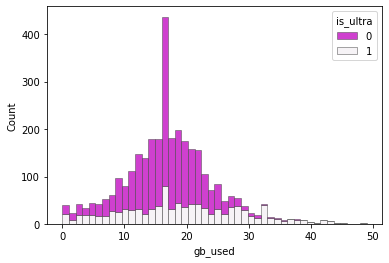

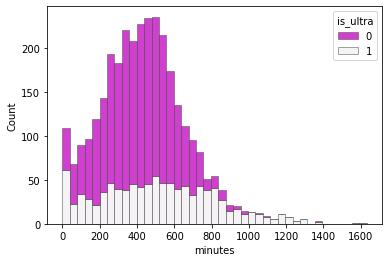

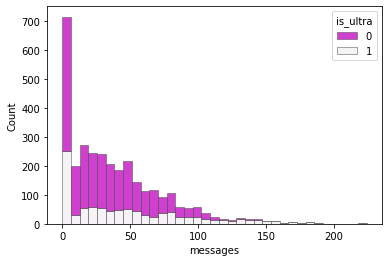

In [59]:
for column in ['gb_used','minutes','messages']:
    sns.histplot(
        data,
        x=column, hue="is_ultra",
        multiple="stack",
        palette="light:m_r",
        edgecolor=".3",
        linewidth=.5,
       )
    plt.show()

К сожалению, такого признака нет, данные распределены равномерно и не разделяются. Странное поведение у пользователей, они зачем-то на Смарте получают больше услуг, чем на Ультре и наоборот на Ультре не пользуются услугами. Если уж пользователи не определились, тогда понятно, почему наша модель предсказывает немногим лучше, чем если мы все заполним Смартами.

Для проверки используем DummyClassifier. Попробуем его с разными опциями. Доступны опции “most_frequent”, “prior”, “stratified”, “uniform”, “constant”. На сколько я понял “most_frequent” и “prior” примерно одно и то же. "constan" в нашем случае тоже означает, что все тарифы будут Смарт. Попробуем варианты “stratified”, “uniform”.

In [60]:
dummy_clf = DummyClassifier(strategy="prior",random_state=1234)
dummy_clf.fit(features_train_no_calls, target_train)
predictions_dummy = dummy_clf.predict(features_test_no_calls)

In [61]:
accuracy_score(target_test, predictions_dummy),recall_score(target_test, predictions_dummy),precision_score(target_test, predictions_dummy,average='micro')

(0.6936236391912908, 0.0, 0.6936236391912908)

In [62]:
dummy_clf = DummyClassifier(strategy="stratified",random_state=1234)
dummy_clf.fit(features_train_no_calls, target_train)
predictions_dummy = dummy_clf.predict(features_test_no_calls)

In [63]:
accuracy_score(target_test, predictions_dummy),recall_score(target_test, predictions_dummy),precision_score(target_test, predictions_dummy)

(0.5987558320373251, 0.38071065989847713, 0.35545023696682465)

In [64]:
dummy_clf = DummyClassifier(strategy="uniform",random_state=1234)
dummy_clf.fit(features_train_no_calls, target_train)
predictions_dummy = dummy_clf.predict(features_test_no_calls)

In [65]:
accuracy_score(target_test, predictions_dummy),recall_score(target_test, predictions_dummy),precision_score(target_test, predictions_dummy)

(0.4572317262830482, 0.4517766497461929, 0.2696969696969697)

Наши модели точно лучше.

## Вывод.

- Тарифом Ультра пользуется примерно 30% всех пользователей, поэтому если мы везде предскважем Смарт, то получим точность ~0.7. Поэтому точность наших моделей должна быть выше 0.7.
- У дерева решений при глубине дерева равной 5 точность на валидационной выборке 0.79 а на тестовой 0.81. При этом в тех случаях, где заведомо должен быть Смарт или Ультра дерево решений дает правильный ответ (даже если все нули).
- У случайного леса наибольшая точность на валидационной выборке равна 0.82 при количестве деревьев 30 и глубине 7.Точность на тестовой выборке 0.81. Проверку на адекватность случайный лес прошел с натяжкой, потому что если все поставить по нулям, то он рекомендует Ультру. Такой случай мы исключили, ведь тогда нам не нужен никакой тариф.
- Чтобы случайный лес прошел проверку на адекватность в 0 пришлось снизить количество деревьев и их глубину.
- У логистической регрессии самая низкая точность. На валидационной выборке 0.74, а на тестовой 0.75. При этом проверку на адекватность она прошла и в нуле тоже.
- Рекомендуется ипользовать для решения задачи дерево решений. Эта модель дает точность соспоставимую со случайным лесом и выше чем у логистической регрессии. При этом случайный лес путается с прогнозом в нуле.